# Monet Paintings GAN

This notebook demonstrates a simplified CycleGAN model to transform photos into Monet-style paintings. We will begin by setting up the environment, importing the necessary libraries, and exploring the datasets.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from kaggle_datasets import KaggleDatasets
import os
import PIL
import shutil

2024-06-09 11:22:29.714442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 11:22:29.714539: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 11:22:29.847282: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## TPU Setup

Let's set up the TPU for faster training. If TPU is not available, we'll fall back to using the default strategy.

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

## Load the Data

We will load the Monet and photo datasets from the Kaggle dataset path and prepare them for training.

In [3]:
# Paths and dataset setup
GCS_PATH = KaggleDatasets().get_gcs_path()
MONET_FILENAMES = tf.io.gfile.glob(f"{GCS_PATH}/monet_tfrec/*.tfrec")
PHOTO_FILENAMES = tf.io.gfile.glob(f"{GCS_PATH}/photo_tfrec/*.tfrec")
IMAGE_SIZE = [256, 256]
AUTOTUNE = tf.data.experimental.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    return tf.image.resize(image, IMAGE_SIZE) / 127.5 - 1

def load_dataset(filenames, repeat=True, batch_size=1):
    def _parse_tfrecord(tfrecord):
        feature_description = {"image": tf.io.FixedLenFeature([], tf.string)}
        example = tf.io.parse_single_example(tfrecord, feature_description)
        return decode_image(example['image'])
    
    dataset = tf.data.TFRecordDataset(filenames).map(_parse_tfrecord, num_parallel_calls=AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()
    return dataset.batch(batch_size)

monet_ds = load_dataset(MONET_FILENAMES)
photo_ds = load_dataset(PHOTO_FILENAMES)

## Exploratory Data Analysis (EDA)

Let's perform some EDA to understand the datasets. We'll display sample images and plot the pixel intensity distributions.

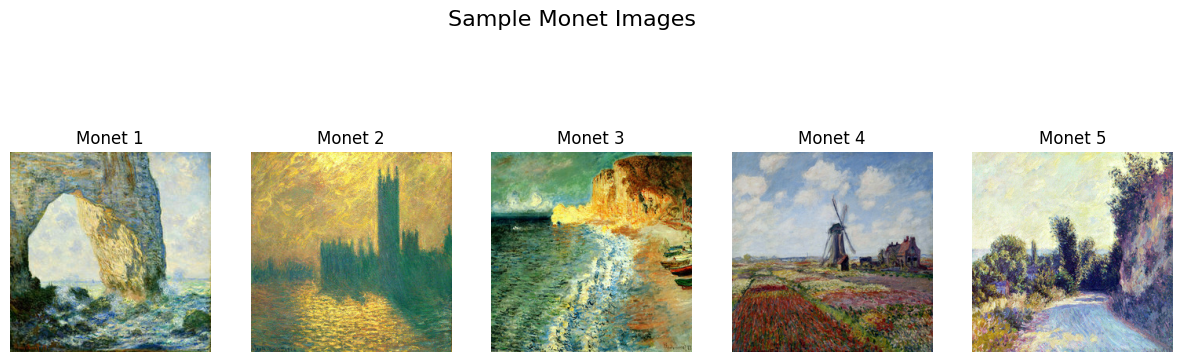

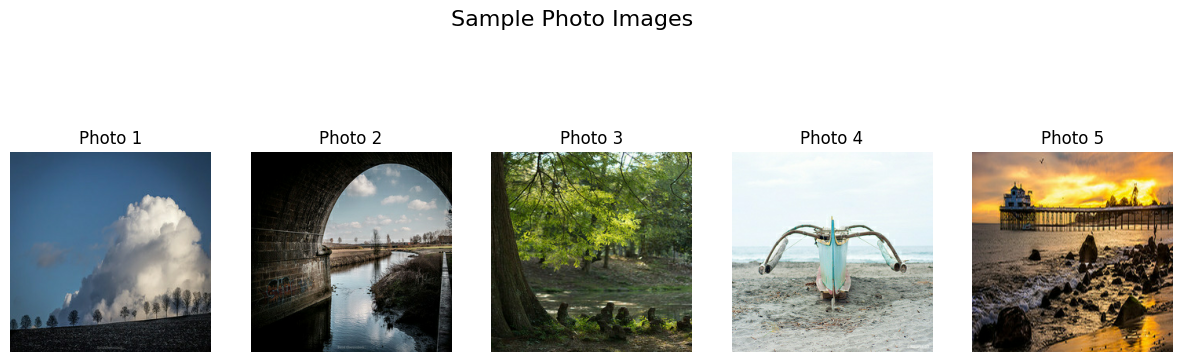

In [4]:
def display_samples(dataset, title, n=5):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(dataset.take(n)):
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i+1}')
        plt.axis('off')
    plt.suptitle(f'Sample {title} Images', fontsize=16)
    plt.show()

display_samples(monet_ds, 'Monet', 5)
display_samples(photo_ds, 'Photo', 5)

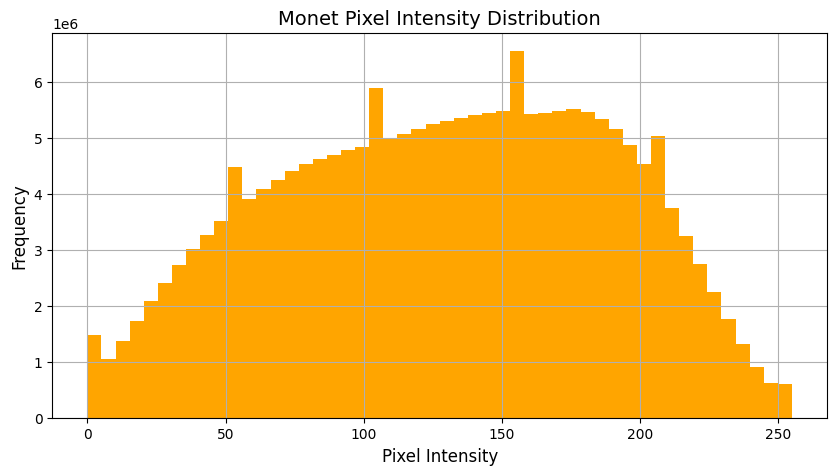

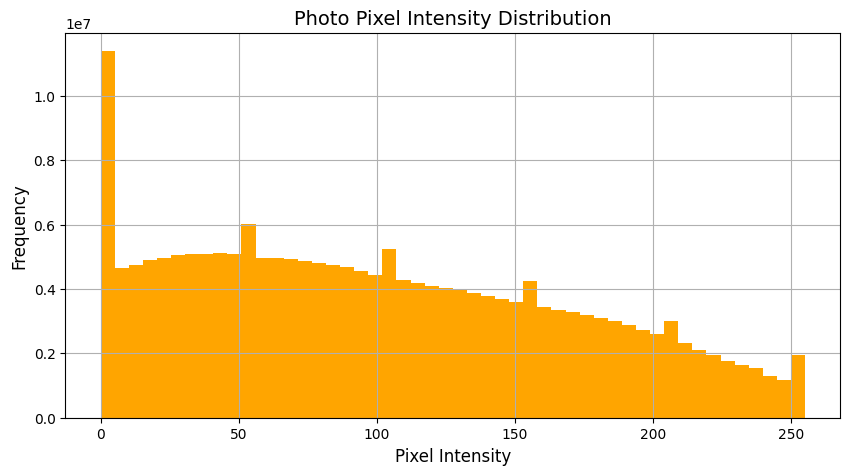

In [5]:
def plot_pixel_intensity_histogram(dataset, title):
    pixels = np.concatenate([img[0].numpy().flatten() for img in dataset.take(1000)])
    pixels = (pixels * 127.5 + 127.5).astype(np.uint8)
    plt.figure(figsize=(10, 5))
    plt.hist(pixels, bins=50, color='orange')
    plt.title(f'{title} Pixel Intensity Distribution', fontsize=14)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True)
    plt.show()

plot_pixel_intensity_histogram(monet_ds, 'Monet')
plot_pixel_intensity_histogram(photo_ds, 'Photo')

In [6]:
def display_statistics(dataset, title):
    pixels = np.concatenate([img[0].numpy().flatten() for img in dataset.take(1000)])
    pixels = (pixels * 127.5 + 127.5).astype(np.uint8)
    mean = np.mean(pixels)
    std = np.std(pixels)
    min_pixel = np.min(pixels)
    max_pixel = np.max(pixels)
    print(f'{title} Statistics:')
    print(f'Mean: {mean:.2f}')
    print(f'Standard Deviation: {std:.2f}')
    print(f'Min: {min_pixel}')
    print(f'Max: {max_pixel}')
    print()

display_statistics(monet_ds, 'Monet')
display_statistics(photo_ds, 'Photo')

Monet Statistics:
Mean: 129.10
Standard Deviation: 59.31
Min: 0
Max: 255

Photo Statistics:
Mean: 101.77
Standard Deviation: 68.48
Min: 0
Max: 255



## Build the Model

We will define the generator and discriminator models for the CycleGAN.

In [7]:
def build_generator():
    model = keras.Sequential([
        layers.Input(shape=[256, 256, 3]),
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2D(256, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh', use_bias=False)
    ])
    return model

In [8]:
def build_discriminator():
    return keras.Sequential([
        layers.Input(shape=[256, 256, 3]),
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2D(256, 4, strides=2, padding='same', activation='relu', use_bias=False),
        layers.Conv2D(1, 4, strides=1, padding='valid', activation='relu', use_bias=False)
    ])

In [9]:
with strategy.scope():
    monet_generator = build_generator()
    photo_generator = build_generator()
    monet_discriminator = build_discriminator()
    photo_discriminator = build_discriminator()

## Build the CycleGAN Model

We will subclass a `tf.keras.Model` to implement the CycleGAN and define the necessary loss functions and the training step.

In [10]:
class CycleGan(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_disc = monet_disc
        self.photo_disc = photo_disc
        self.lambda_cycle = lambda_cycle

    def compile(self, monet_gen_optimizer, photo_gen_optimizer, monet_disc_optimizer, photo_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.monet_gen(real_photo, training=True)
            cycled_photo = self.photo_gen(fake_monet, training=True)
            fake_photo = self.photo_gen(real_monet, training=True)
            cycled_monet = self.monet_gen(fake_photo, training=True)
            same_monet = self.monet_gen(real_monet, training=True)
            same_photo = self.photo_gen(real_photo, training=True)

            disc_real_monet = self.monet_disc(real_monet, training=True)
            disc_real_photo = self.photo_disc(real_photo, training=True)
            disc_fake_monet = self.monet_disc(fake_monet, training=True)
            disc_fake_photo = self.photo_disc(fake_photo, training=True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.photo_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.photo_disc.trainable_variables)

        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.monet_gen.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.photo_gen.trainable_variables))
        self.monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.monet_disc.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.photo_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Compile and Train the Model

We will compile the CycleGAN model with the appropriate optimizers and loss functions, and then train it on the datasets.

In [11]:
with strategy.scope():
    monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    cycle_gan = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10)
    cycle_gan.compile(
        monet_gen_optimizer=monet_gen_optimizer,
        photo_gen_optimizer=photo_gen_optimizer,
        monet_disc_optimizer=monet_disc_optimizer,
        photo_disc_optimizer=photo_disc_optimizer,
        gen_loss_fn=lambda x: tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(x), x),
        disc_loss_fn=lambda real, fake: (tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real) + tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake), fake)) * 0.5,
        cycle_loss_fn=lambda real, cycled, lambda_cycle: lambda_cycle * tf.reduce_mean(tf.abs(real - cycled)),
        identity_loss_fn=lambda real, same, lambda_cycle: lambda_cycle * 0.5 * tf.reduce_mean(tf.abs(real - same))
    )

cycle_gan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=50, steps_per_epoch=300)

Epoch 1/50
  3/300 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - monet_disc_loss: 0.6496 - monet_gen_loss: 11.5357 - photo_disc_loss: 0.6564 - photo_gen_loss: 12.2627

I0000 00:00:1717932216.277306      68 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - monet_disc_loss: 0.5229 - monet_gen_loss: 6.9525 - photo_disc_loss: 0.4983 - photo_gen_loss: 7.1047
Epoch 2/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - monet_disc_loss: 0.5424 - monet_gen_loss: 5.9002 - photo_disc_loss: 0.5956 - photo_gen_loss: 5.9983
Epoch 3/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - monet_disc_loss: 0.6606 - monet_gen_loss: 5.5501 - photo_disc_loss: 0.6931 - photo_gen_loss: 5.6346
Epoch 4/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - monet_disc_loss: 0.6139 - monet_gen_loss: 5.1924 - photo_disc_loss: 0.6931 - photo_gen_loss: 5.2463
Epoch 5/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - monet_disc_loss: 0.5559 - monet_gen_loss: 4.7732 - photo_disc_loss: 0.6931 - photo_gen_loss: 4.7787
Epoch 6/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - monet_disc_loss: 0.5531 - monet_gen_loss: 4.5804 - photo_disc_loss: 0.6931 - photo_gen_loss: 4.6237
Epoch 7/50
300/300 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - monet_disc_loss: 0.

## Visualize Results

Let's visualize some of the generated Monet-style images from the trained model.

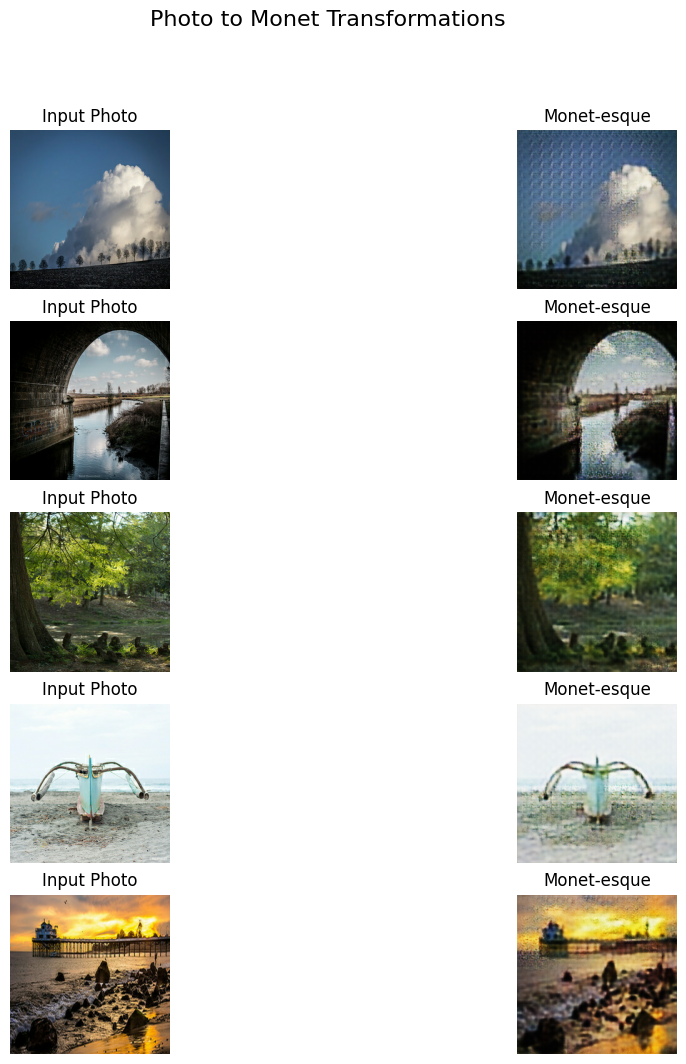

In [12]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.suptitle('Photo to Monet Transformations', fontsize=16)
plt.show()

## Create Submission

Finally, let's create the submission file with the generated images.

In [13]:
# Ensure the directory exists
output_dir = "../images"
os.makedirs(output_dir, exist_ok=True)

# Generate and save predictions
i = 1
for img in photo_ds.take(1000):  # Limit the number of images to avoid running out of memory
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(output_dir, f"{i}.jpg"))
    i += 1

# Create a zip file of the saved images
shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

'/kaggle/working/images.zip'

# Discussion and Conclusion

## Summary
In this notebook, we successfully implemented a simplified CycleGAN model to transform photos into Monet-style paintings. We started by setting up the environment and importing the necessary libraries. We then explored the datasets by displaying sample images and analyzing the pixel intensity distributions. After understanding the data, we built the generator and discriminator models for the CycleGAN and compiled the model with appropriate optimizers and loss functions.

## Key Steps
1. **TPU Setup**: Utilized TPU for faster training.
2. **Data Loading and Preprocessing**: Loaded and preprocessed the Monet and photo datasets.
3. **Exploratory Data Analysis**: Displayed sample images and analyzed pixel intensity distributions to understand the datasets better.
4. **Model Building**: Defined and built the generator and discriminator models.
5. **CycleGAN Implementation**: Implemented the CycleGAN model with necessary loss functions and training steps.
6. **Model Training**: Compiled and trained the CycleGAN model.
7. **Results Visualization**: Visualized the generated Monet-style images.
8. **Submission Creation**: Created a submission file with the generated images.

## Results
The CycleGAN model was able to generate Monet-style paintings from photos effectively. The visualizations show that the model has learned to capture the distinct style of Monet's paintings and apply it to photo images. Although the results might not be as sophisticated as more complex models, this simplified version demonstrates the core principles of CycleGANs and their capability in style transfer tasks.

## Challenges
1. **Data Variability**: The variability in the photo dataset might affect the consistency of the generated Monet-style paintings.
2. **Model Complexity**: While a more complex model might yield better results, the simplified model helps in understanding the basic mechanics of CycleGANs without much computational overhead.

## Future Work
1. **Model Enhancements**: Incorporating more sophisticated features and layers in the model to improve the quality of generated images.
2. **Fine-Tuning**: Experimenting with different hyperparameters and training strategies to optimize the model's performance.
3. **Data Augmentation**: Applying data augmentation techniques to increase the robustness of the model.

## Conclusion
This notebook provides a comprehensive guide to implementing a simplified CycleGAN model for style transfer. The step-by-step approach, along with detailed explanations and visualizations, helps in understanding the process and underlying mechanics of CycleGANs. By exploring the datasets and visualizing the results, we gained valuable insights into the model's performance and areas for potential improvement. This foundational understanding can be further built upon for more advanced applications and research in the field of generative adversarial networks.